In [5]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Data Preprocessing

In [6]:
def createDatasets():
    # Change the path according to your system configuration
    path = r"C:/Users/afs18/Downloads/"
    real_folders = ['data/2017/real_accounts1.csv', 'data/2015/real_accounts2.csv', 'data/2015/real_accounts3.csv']
    bot_folders = ['data/2017/bots1.csv',
                         'data/2017/bots2.csv',
                         'data/2017/bots3.csv',
                         'data/2017/bots4.csv']
    real_users_list = []
    real_tweet_list = []  
    for folder in real_folders:
        df_users = pd.read_csv(path + folder+"/users.csv",index_col="id", encoding="latin-1", low_memory=False);
        df_users["source_f"] = folder; 
        real_users_list.append(df_users);
        df_tweets = pd.read_csv(path + folder+"/tweets.csv",index_col="id", encoding="latin-1", low_memory=False);
        df_tweets["source_f"] = folder; 
        real_tweet_list.append(df_tweets);
    real_tweets = pd.concat(real_tweet_list)
    real_users = pd.concat(real_users_list)
    real_users["is_bot"] = 0
    
    bot_users_list = []
    bot_tweets_list = []
    for folder in bot_folders:
        df_users = pd.read_csv(path + folder+"/users.csv",index_col="id", encoding="latin-1", low_memory=False);
        df_users["source_f"] = folder;
        bot_users_list.append(df_users);    
        df_tweets = pd.read_csv(path + folder+"/tweets.csv",index_col="id", encoding="latin-1", low_memory=False);
        df_tweets["source_f"] = folder;
        bot_tweets_list.append(df_tweets);
    bot_tweets = pd.concat(bot_tweets_list)
    bot_users = pd.concat(bot_users_list)
    bot_users["is_bot"] = 1
    
    users = pd.concat([bot_users,real_users])
    tweets = pd.concat([bot_tweets,real_tweets])

    # Remove users with no tweets
    users["is_bot"] = users["is_bot"][users.index.isin(tweets.set_index("user_id").index)]
    users = users[users.index.isin(tweets.set_index("user_id").index)]
    
    del users["following"];
    del tweets["contributors"];
    del users["notifications"];
    del tweets["favorited"];
    del tweets["geo"];
    del users["contributors_enabled"];
    del users["follow_request_sent"];    
    del users["test_set_1"];
    del users["test_set_2"];
    del tweets["retweeted"];
    
    # Change timestamp into datetime
    tweets["timestamp_dt"] = pd.to_datetime(tweets["timestamp"],format='%Y-%m-%d %H:%M:%S')
    del tweets["timestamp"]

    return users, tweets                                   

In [7]:
users, tweets = createDatasets()

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/afs18/Downloads/data/2017/real_accounts1.csv/users.csv'

# Feature Engineering

In [41]:
def featureEngineering(users, tweets):
    # Add a new feature which is the ratio of friends count to followers counts
    users.loc[:,"friend_follower_ratio"] = users["friends_count"] / (users["followers_count"] + 1)
    
    
    # Get the average of the tweets features corresponding to every user
    average_tweets = tweets[["num_hashtags", "retweet_count", "favorite_count", "num_mentions", "num_urls", "user_id"]].groupby("user_id").mean()
    
    # Replace missing values with 0
    average_tweets = average_tweets.fillna(0)
    
    # Add _per_tweet to the features names
    users = users.join(average_tweets.add_suffix("_per_tweet"))
    
    users.loc[:,"unique_tweet_place"] = tweets.groupby("user_id").place.nunique()
    
    # Add a new feature which is the variance of user's tweets per hour
    tweets.loc[:,"date"] = tweets.timestamp_dt.dt.date
    tweets.loc[:,"hour"] = tweets.timestamp_dt.dt.hour
    variance_tweet_rate = tweets.groupby(["user_id", "date", "hour"]).size().groupby("user_id").var()
    variance_tweet_rate.rename("variance_in_tweet_rate", inplace=True)
    users = users.join(variance_tweet_rate)
    
    return users, tweets

In [42]:
users, tweets = featureEngineering(users, tweets)

In [48]:
def featureSelection(users):
    final_df = users[['favourites_count','followers_count','friends_count','verified','friend_follower_ratio','num_hashtags_per_tweet','retweet_count_per_tweet','favorite_count_per_tweet','num_mentions_per_tweet','num_urls_per_tweet','unique_tweet_place','variance_in_tweet_rate', 'is_bot']]
    values = {"verified":0, "variance_in_tweet_rate":0}
    final_df = final_df.fillna(value=values)
    X = final_df.iloc[:,:-1]
    y = final_df.iloc[:, -1:]
    return X, y

X, y = featureSelection(users)

# Data Normalization

In [51]:
def normalizeData(X, isTrain=True):
    if(isTrain):
        scaler = StandardScaler()
        scaler = scaler.fit(X)
        pickle.dump(scaler, open("Pickle/scaler.pickle", "wb"))
        X.loc[:,:] = scaler.transform(X)
    else:
        scaler = pickle.load(open("Pickle/scaler.pickle", "rb"))
        X.loc[:,:] = scaler.transform(X)
        
    return X
X = normalizeData(X)

# Splitting the Data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

pickle.dump(X_train, open("Pickle/X_train.pickle", "wb"))
pickle.dump(X_val, open("Pickle/X_val.pickle", "wb"))
pickle.dump(y_train, open("Pickle/y_train.pickle", "wb"))
pickle.dump(y_val, open("Pickle/y_val.pickle", "wb"))
pickle.dump(X_test, open("Pickle/X_test.pickle", "wb"))
pickle.dump(y_test, open("Pickle/y_test.pickle", "wb"))

NameError: name 'X' is not defined

In [59]:
print("X_train: {}".format(len(X_train)))
print("y_train: {}".format(len(y_train)))
print("X_val: {}".format(len(X_val)))
print("y_val: {}".format(len(y_val)))
print("X_test: {}".format(len(X_test)))
print("y_test: {}".format(len(y_test)))

X_train: 5364
y_train: 5364
X_val: 1788
y_val: 1788
X_test: 1789
y_test: 1789


# #NAIVE BAISE

In [57]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn import svm

In [58]:
file = open('./Pickle/X_test.pickle', 'rb')
X_test = pickle.load(file)
file = open('./Pickle/X_train.pickle', 'rb')
X_train = pickle.load(file)
file = open('./Pickle/X_val.pickle', 'rb')
X_val = pickle.load(file)
file = open('./Pickle/y_test.pickle', 'rb')
y_test = pickle.load(file)
file = open('./Pickle/y_train.pickle', 'rb')
y_train = pickle.load(file)
file = open('./Pickle/y_val.pickle', 'rb')
y_val = pickle.load(file)
print(y_train.shape)

(5364, 1)


In [67]:
gnb = svm.SVC()
hyper = {'C':[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1],
         'gamma':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
         'kernel':['rbf','linear']
        }
grid=GridSearchCV(estimator=gnb,param_grid=hyper,verbose=True)
grid.fit(X_train, y_train.values.ravel()).predict(X_test)
print(grid.best_params_)
print(grid.best_estimator_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
{'C': 0.9, 'gamma': 0.6, 'kernel': 'rbf'}
SVC(C=0.9, gamma=0.6)


In [69]:
from sklearn.metrics import classification_report

grid_predictions = grid.predict(X_test)
 
# print classification report
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96       605
         1.0       0.99      0.97      0.98      1184

    accuracy                           0.97      1789
   macro avg       0.97      0.97      0.97      1789
weighted avg       0.97      0.97      0.97      1789



In [79]:
filename = 'SVM.sav'
pickle.dump(grid, open(filename, 'wb'))
# load the model from disk.
# loaded_model = pickle. load(open(filename, 'rb'))

Text(0, 0.5, 'Error')

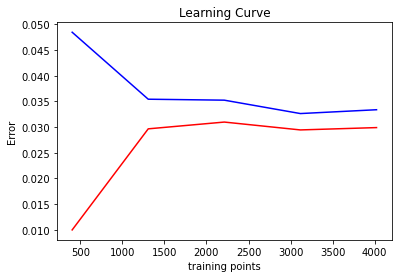

In [76]:
from sklearn.model_selection import learning_curve    
import matplotlib.pyplot as plt

sizes, tr_scores, t_scores = learning_curve(
    estimator=gnb, X=X_train, y=y_train.values.ravel(),cv=4,error_score='raise')

tr_mean = np.mean(tr_scores, axis=1)
tr_std = np.std(tr_scores, axis=1)
t_mean = np.mean(t_scores, axis=1)
t_std = np.std(t_scores, axis=1)

plt.plot(sizes, 1 - tr_mean, color='red', markersize=4, label='Training Data')
plt.plot(sizes, 1 -  t_mean, color='blue', markersize=5, label='Validating Data')
plt.title('Learning Curve')
plt.xlabel('training points')
plt.ylabel('Error')